In [2]:
import numpy as np
import matplotlib.pyplot as plt
from trainSpringerSegmentationAlgorithm import trainSpringerSegmentationAlgorithm
from runSpringerSegmentationAlgorithm import runSpringerSegmentationAlgorithm
from scipy.signal import envelope, butter, filtfilt

In [3]:
include_wavelet = 0
featuresFs = 50
fs = 1000  # original sampling frequency

In [4]:
audio_train = np.loadtxt('/home/david/Documents/pcg-ecg-analysis/mediciones_simultaneas/DAVID171225_2-JORGE-20051201021025/pcg_cut_matlab.txt')
envol = envelope(audio_train, residual=None)
# low pass filter for the envelope
lowcut = 40.0
fs = 1000.0
b, a = butter(1, lowcut, btype='lowpass', fs=fs)
envol = filtfilt(b, a, envol)
r_peaks_train = np.loadtxt('/home/david/Documents/pcg-ecg-analysis/mediciones_simultaneas/DAVID171225_2-JORGE-20051201021025/R_marks_adjusted.txt', dtype=int)
t_points_train = np.loadtxt('/home/david/Documents/pcg-ecg-analysis/mediciones_simultaneas/DAVID171225_2-JORGE-20051201021025/T_marks_adjusted.txt', dtype=int)
x = np.arange(len(audio_train))

audio_test = np.loadtxt('/home/david/Documents/pcg-ecg-analysis/mediciones_simultaneas/DAVID171225_3-JORGE-20051201023210/pcg_cut_matlab.txt')
r_peaks_test = np.loadtxt('/home/david/Documents/pcg-ecg-analysis/mediciones_simultaneas/DAVID171225_3-JORGE-20051201023210/R_marks_adjusted.txt', dtype=int)
t_points_test = np.loadtxt('/home/david/Documents/pcg-ecg-analysis/mediciones_simultaneas/DAVID171225_3-JORGE-20051201023210/T_marks_adjusted.txt', dtype=int)
envol_test = envelope(audio_test, residual=None)
# low pass filter for the envelope
envol_test = filtfilt(b, a, envol_test)
envol_test = envol_test/np.max(np.abs(envol_test))
x_test = np.arange(len(audio_test))

In [88]:
audio_segments_train = []
audio_train_annotations = []

for i in range(len(r_peaks_train)-1):
    r_peak = r_peaks_train[i]
    t_point = t_points_train[i]
    start = max(0, r_peak - 300)  # 200 ms before R peak
    end = r_peaks_train[i+1] - 300
    segment = audio_train[start:end]
    audio_segments_train.append(segment)
    annotations = {
        'R_peak': r_peak,
        'T_point': t_point
    }
    audio_train_annotations.append(annotations)


def pcg_graph_denoising_core(Y, lambda1=0.1, lambda2=0.1, max_iter=100, tol=1e-5):
    """
    (Esta es la misma función matemática iterativa de las Eq. 5 y 6 que te mostré antes, 
    fiel al 100% a la matemática del paper para matrices NxT).
    """
    N, T = Y.shape
    C = np.corrcoef(Y) 
    A = (C > 0.6).astype(float)
    np.fill_diagonal(A, 0) 
    
    D = np.diag(np.sum(A, axis=1))
    L = D - A
    
    Psi = Y.copy() 
    I_N = np.eye(N) 
    
    for i in range(max_iter):
        eps = 1e-8 
        norms = np.sqrt(np.sum(Psi**2, axis=1) + eps)
        Gamma = np.diag(1.0 / norms)
        
        M = I_N + lambda1 * Gamma + lambda2 * L
        Psi_new = np.linalg.solve(M, Y)
        
        diff = np.linalg.norm(Psi_new - Psi, ord='fro') / (np.linalg.norm(Psi, ord='fro') + eps)
        Psi = Psi_new
        if diff < tol:
            break
            
    return Psi


In [146]:
matrix_dict = {}
# find max length of segments
max_length = max(len(segment) for segment in audio_segments_train)

# fill segments with zeros to have the same length and store in dictionary, save the original length in the dictionary as well
for i in range(10):
    matrix_dict[i] = {
        'original_length': len(audio_segments_train[i]),
        'segment': np.pad(audio_segments_train[i], (0, max_length - len(audio_segments_train[i])), mode='constant')
    }

matrix = np.vstack([matrix_dict[i]['segment'] for i in range(10)])

matrix_denoised = pcg_graph_denoising_core(matrix, lambda1=0.1, lambda2=0.1)

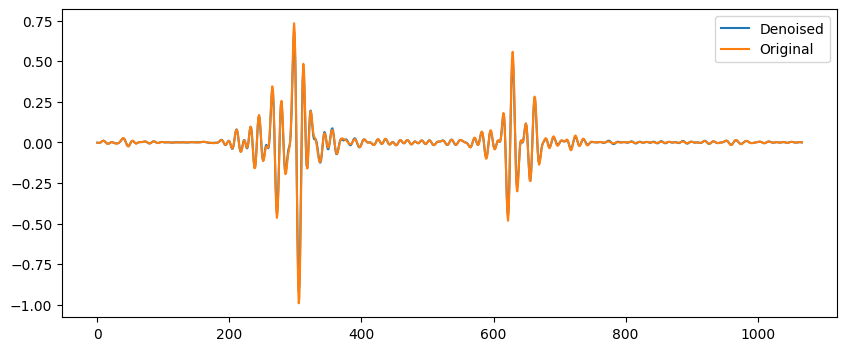

In [160]:
n = np.random.randint(0, 5)
plt.figure(figsize=(10, 4))
plt.plot(matrix_denoised[n, :matrix_dict[n]['original_length']], label='Denoised')
plt.plot(matrix_dict[n]['segment'][:matrix_dict[n]['original_length']], label='Original')
plt.legend()
plt.show()

In [ ]:
# Now we segmenting the audio and r_peaks, t_points into 10-second segments
segment_length = 10000  # 10 seconds at 1000 Hz
num_segments = len(audio_train) // segment_length
audio_segments_train = []
envol_segments_train = []
audio_train_annotations = []
for i in range(num_segments):
    start = i * segment_length
    end = (i + 1) * segment_length
    audio_segments_train.append(audio_train[start:end])
    envol_segments_train.append(envol[start:end])
    # r_peaks_segments_train.append(r_peaks_train[(r_peaks_train >= start) & (r_peaks_train < end)] - start)
    # t_points_segments_train.append(t_points_train[(t_points_train >= start) & (t_points_train < end)] - start)
    # we need to add the r_peaks and t_points as array of Nx2, where thre first column are the r_peaks and the second column are the t_points
    r_peaks_segment = r_peaks_train[(r_peaks_train >= start) & (r_peaks_train < end)] - start
    r_peaks_segment = np.rint(r_peaks_segment/20)
    t_points_segment = t_points_train[(t_points_train >= start) & (t_points_train < end)] - start
    t_points_segment = np.rint(t_points_segment/20)

    if len(r_peaks_segment) > len(t_points_segment):
        r_peaks_segment = r_peaks_segment[:len(t_points_segment)]
    elif len(t_points_segment) > len(r_peaks_segment):
        t_points_segment = t_points_segment[1:len(t_points_segment)]
    # concatenate the r_peaks and t_points into a single array of Nx2
    annotations = np.vstack((r_peaks_segment, t_points_segment)).T
    audio_train_annotations.append(annotations)

# The same for the test set
segment_test_length = 1000
num_segments_test = len(audio_test) // segment_test_length
audio_segments_test = []
envol_segments_test = []
audio_test_annotations = []
for i in range(num_segments_test):
    start = i * segment_test_length
    end = (i + 1) * segment_test_length
    audio_segments_test.append(audio_test[start:end])
    envol_segments_test.append(envol_test[start:end])
    # r_peaks_segments_test.append(r_peaks_test[(r_peaks_test >= start) & (r_peaks_test < end)] - start)
    # t_points_segments_test.append(t_points_test[(t_points_test >= start) & (t_points_test < end)] - start)
    r_peaks_segment = r_peaks_test[(r_peaks_test >= start) & (r_peaks_test < end)] - start
    t_points_segment = t_points_test[(t_points_test >= start) & (t_points_test < end)] - start

    if len(r_peaks_segment) > len(t_points_segment):
        r_peaks_segment = r_peaks_segment[:len(t_points_segment)]
    elif len(t_points_segment) > len(r_peaks_segment):
        t_points_segment = t_points_segment[1:len(t_points_segment)]
    annotations = np.vstack((r_peaks_segment, t_points_segment)).T
    audio_test_annotations.append(annotations)

logistic_regression_B_matrix, pi_vector, total_obs_distribution = trainSpringerSegmentationAlgorithm(audio_segments_train, audio_train_annotations, fs)
assigned_states = runSpringerSegmentationAlgorithm(
        audio_test[:1000], #audio_segments_test[n],
        fs,
        logistic_regression_B_matrix,
        pi_vector, total_obs_distribution,
        figures=False
        )